# Regresión Logística

En este notebook, utilizaremos la regresión logística para entrenar un algoritmo de clasificación que permita establecer un modelo que prediga los sobrevivientes del dataset Titanic

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Carga de Datos y Análisis Exploratorio

In [31]:
df = pd.read_csv('titanic.csv')

In [32]:
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


<Axes: xlabel='Survived', ylabel='count'>

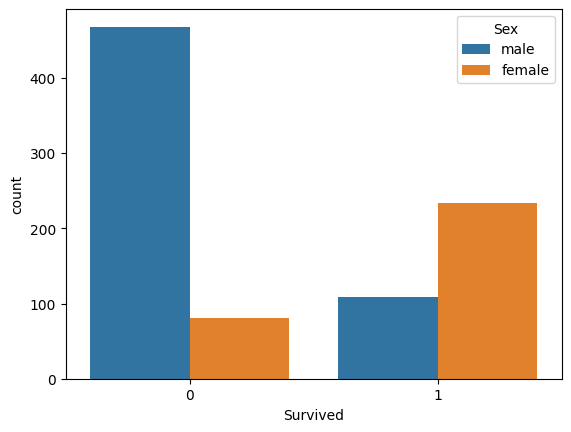

In [33]:
sns.countplot(x="Survived", hue="Sex", data=df)

<Axes: xlabel='Survived', ylabel='count'>

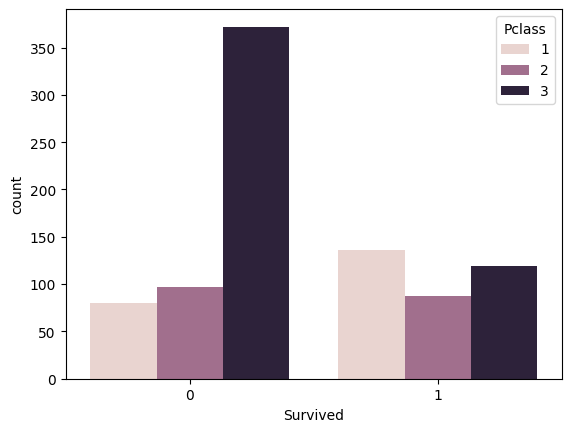

In [34]:
sns.countplot(x="Survived", hue="Pclass", data=df)

### Valores perdidos

In [35]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

La cabina no aporta mucho en el análisis, pero la edad es una variable importante para predecir si una persona sobrevivió o no a la trajedia. A continuación, una forma de "visualizar" los valores perdidos.

<Axes: >

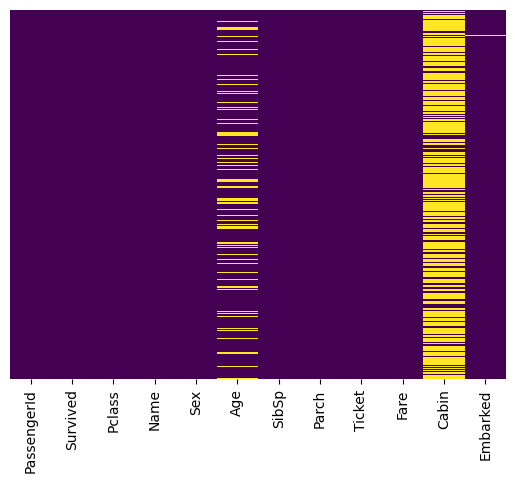

In [36]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap="viridis")

Haremos una imputación de la edad del pasajero en función del promedio de edad de la clase en la que viajaba.

<Axes: xlabel='Pclass', ylabel='Age'>

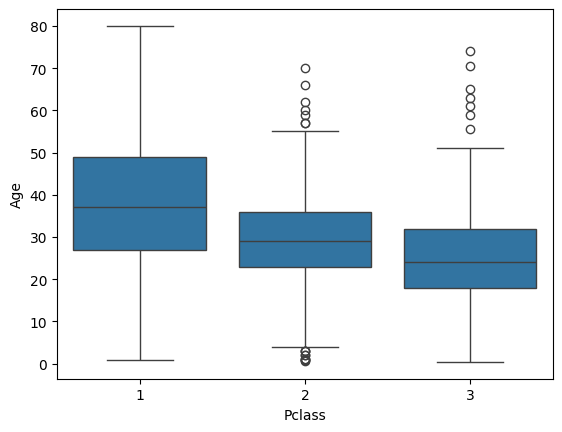

In [37]:
sns.boxplot(x='Pclass', y='Age', data=df)

In [38]:
# Dos formas distintas de hacer esto, ambas funcionan (mejor la opción sin cometario)
#edades = round(df.groupby('Pclass').mean(numeric_only=True)['Age'])
edades = round(df.groupby('Pclass')['Age'].mean())
edades

Pclass
1    38.0
2    30.0
3    25.0
Name: Age, dtype: float64

In [39]:
# creamos una funcion que imputa la edad en caso de estar nula
def imputar_edad(cols):
    edad = cols[0]
    pclass = cols[1]
    if(pd.isnull(edad)):
        if(pclass==1):
            return 38
        if(pclass==2):
            return 30
        if(pclass==3):
            return 25
    else:
        return edad

In [40]:
df['Age'] = df[['Age','Pclass']].apply(imputar_edad, axis=1)

C:\Users\adria\AppData\Local\Temp\ipykernel_37252\3628055789.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  edad = cols[0]
C:\Users\adria\AppData\Local\Temp\ipykernel_37252\3628055789.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pclass = cols[1]


In [41]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Formulación del modelo

En esta sección seleccionaremos las variables que incorporaremos en la matriz de predictores "X" y en el vector de resultados "y", ya que no todas las columnas son de utilidad.

In [42]:
# Selección de variables predictoras y objetivo
X = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
y = df['Survived']

### Tratamiento de variables categoricas

La variable Embarked es categórica, debemos transformarla en variable dummy para incorporarla en el modelo.

In [43]:
# Convertir variables categóricas a variables dummy
X = pd.get_dummies(X, columns=['Sex', 'Embarked'], drop_first=True)

In [44]:
# Dividir en conjunto de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [45]:
# Estandarización de variables numéricas
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train[['Age', 'Fare']] = scaler.fit_transform(X_train[['Age', 'Fare']])
X_test[['Age', 'Fare']] = scaler.transform(X_test[['Age', 'Fare']])

### Validación cruzada

In [46]:
# Validación cruzada para evaluar el modelo
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
logreg = LogisticRegression(max_iter=1000)
scores = cross_val_score(logreg, X_train, y_train, cv=5, scoring='accuracy')
print(f'Accuracy promedio (CV=5): {scores.mean():.3f} +/- {scores.std():.3f}')

Accuracy promedio (CV=5): 0.804 +/- 0.011


In [47]:
# Entrenar el modelo con todos los datos de entrenamiento
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

### Entrenamiento de la Regresión Logística

In [48]:
# Coeficientes del modelo
pd.Series(logreg.coef_[0], index=X_train.columns)

Pclass       -1.151787
Age          -0.603200
SibSp        -0.316119
Parch        -0.045979
Fare          0.114195
Sex_male     -2.544555
Embarked_Q    0.235299
Embarked_S   -0.297104
dtype: float64

In [49]:
# Intercepto del modelo
logreg.intercept_

array([4.04313973])

### Realizando predicciones

In [50]:
# Realizar predicciones sobre el set de prueba
y_pred = logreg.predict(X_test)

In [51]:
# Probabilidades de predicción
y_proba = logreg.predict_proba(X_test)[:,1]
y_proba[:10]

array([0.20110269, 0.1384202 , 0.17225917, 0.10019577, 0.04687237,
       0.11315824, 0.23208151, 0.88047058, 0.08873987, 0.87115281])

In [52]:
# Mostrar algunas predicciones junto a los valores reales
pd.DataFrame({'Real': y_test, 'Predicción': y_pred}).head(10)

,Real,Predicción
625,0,0
566,0,0
459,0,0
804,1,0
338,1,0
745,0,0
277,0,0
473,1,1
157,0,0
427,1,1


### Evaluación del Modelo

Accuracy en test: 0.810


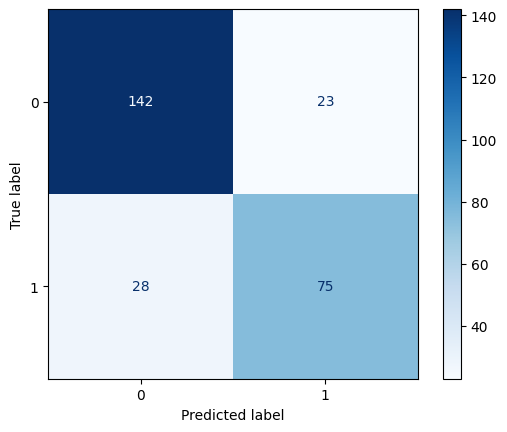

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       165
           1       0.77      0.73      0.75       103

    accuracy                           0.81       268
   macro avg       0.80      0.79      0.80       268
weighted avg       0.81      0.81      0.81       268



In [53]:
# Evaluación del modelo: accuracy, matriz de confusión y reporte de clasificación
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy en test: {acc:.3f}')
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()
print(classification_report(y_test, y_pred))

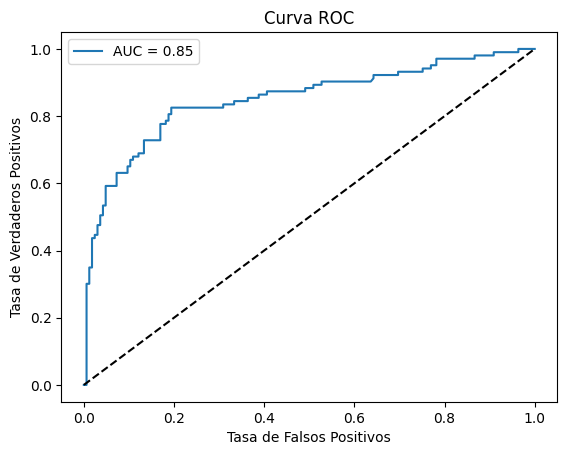

In [54]:
# Curva ROC y AUC
from sklearn.metrics import roc_curve, roc_auc_score, recall_score
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

In [55]:
# Importancia de las variables (coeficientes absolutos)
import numpy as np
importances = np.abs(logreg.coef_[0])
feature_names = X_train.columns
sorted_idx = np.argsort(importances)[::-1]
for idx in sorted_idx:
    print(f'{feature_names[idx]}: {importances[idx]:.3f}')

Sex_male: 2.545
Pclass: 1.152
Age: 0.603
SibSp: 0.316
Embarked_S: 0.297
Embarked_Q: 0.235
Fare: 0.114
Parch: 0.046


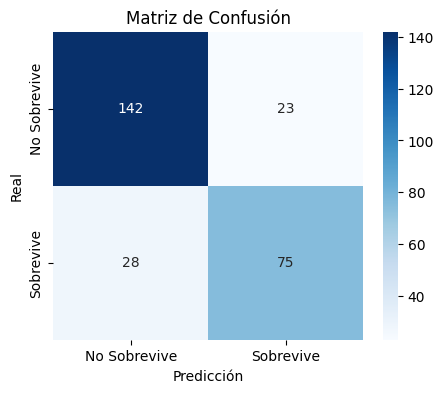

In [56]:
# Matriz de confusión con etiquetas
import seaborn as sns
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Sobrevive','Sobrevive'], yticklabels=['No Sobrevive','Sobrevive'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

In [57]:
# Ajuste del umbral de decisión para maximizar recall de sobrevivientes
umbral = 0.3
y_pred_umbral = (y_proba >= umbral).astype(int)
print(confusion_matrix(y_test, y_pred_umbral))
print(classification_report(y_test, y_pred_umbral))

[[119  46]
 [ 18  85]]
              precision    recall  f1-score   support

           0       0.87      0.72      0.79       165
           1       0.65      0.83      0.73       103

    accuracy                           0.76       268
   macro avg       0.76      0.77      0.76       268
weighted avg       0.78      0.76      0.76       268



In [58]:
# Comparar accuracy y recall con y_pred y y_pred_umbral
print('Accuracy estándar:', accuracy_score(y_test, y_pred))
print('Recall estándar:', recall_score(y_test, y_pred))
print('Accuracy con umbral 0.3:', accuracy_score(y_test, y_pred_umbral))
print('Recall con umbral 0.3:', recall_score(y_test, y_pred_umbral))

Accuracy estándar: 0.8097014925373134
Recall estándar: 0.7281553398058253
Accuracy con umbral 0.3: 0.7611940298507462
Recall con umbral 0.3: 0.8252427184466019


In [59]:
# Conclusión final del modelo
from IPython.display import display, Markdown
display(Markdown('''\
**Conclusión:**\n\nEl modelo de regresión logística permite predecir la supervivencia en el Titanic con un desempeño razonable. El ajuste del umbral de decisión puede priorizar la identificación de sobrevivientes (mayor recall), aunque a costa de más falsos positivos. La importancia de las variables muestra que el sexo, la clase y la edad son factores clave en la predicción.\n'''))

**Conclusión:**

El modelo de regresión logística permite predecir la supervivencia en el Titanic con un desempeño razonable. El ajuste del umbral de decisión puede priorizar la identificación de sobrevivientes (mayor recall), aunque a costa de más falsos positivos. La importancia de las variables muestra que el sexo, la clase y la edad son factores clave en la predicción.
